In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
import matplotlib.pyplot as plt
from tqdm import tqdm

In [8]:
device = torch.device ("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
# Load CIFAR-10 dataset
batch_size = 256
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to fit ViT input
    transforms.ToTensor(),           # Convert to Tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size= batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:05<00:00, 28427689.89it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [23]:
# Load the pretrained ViT model
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=10)
model = model.to(device)
# Freeze the backbone layers
for param in model.vit.parameters():
    param.requires_grad = False

# Only train the classifier head
for param in model.classifier.parameters():
    param.requires_grad = True

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
num_epochs = 3
train_accuracy_list = []
test_accuracy_list = []

In [25]:
def train(model, train_loader, criterion, optimizer, device):
        model.train()
        correct_train = 0
        total_train = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).logits  # Get the logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = correct_train / total_train
        train_accuracy_list.append(train_accuracy)
        return train_accuracy,loss

In [26]:
def test(model, test_loader, device):
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = correct_test / total_test
    test_accuracy_list.append(test_accuracy)
    return test_accuracy

In [27]:
for i in tqdm(range(num_epochs)):
    train_accuracy, loss = train(model, train_loader, criterion, optimizer, device)
    print(f'Epoch [{i+1}/{num_epochs}], Training Accuracy: {train_accuracy:.4f}, Loss: {loss.item():.4f}')
    test_accuracy = test(model, test_loader, device)
    print(f'Testing Accuracy: {test_accuracy:.4f}')

100%|██████████| 196/196 [09:35<00:00,  2.94s/it]


Epoch [1/3], Training Accuracy: 0.9288, Loss: 0.1968


 33%|███▎      | 1/3 [11:30<23:00, 690.42s/it]

Testing Accuracy: 0.9588



100%|██████████| 196/196 [09:35<00:00,  2.94s/it]


Epoch [2/3], Training Accuracy: 0.9625, Loss: 0.2823


 67%|██████▋   | 2/3 [23:00<11:30, 690.39s/it]

Testing Accuracy: 0.9607



100%|██████████| 196/196 [09:35<00:00,  2.94s/it]


Epoch [3/3], Training Accuracy: 0.9646, Loss: 0.1475


100%|██████████| 3/3 [34:31<00:00, 690.50s/it]

Testing Accuracy: 0.9611


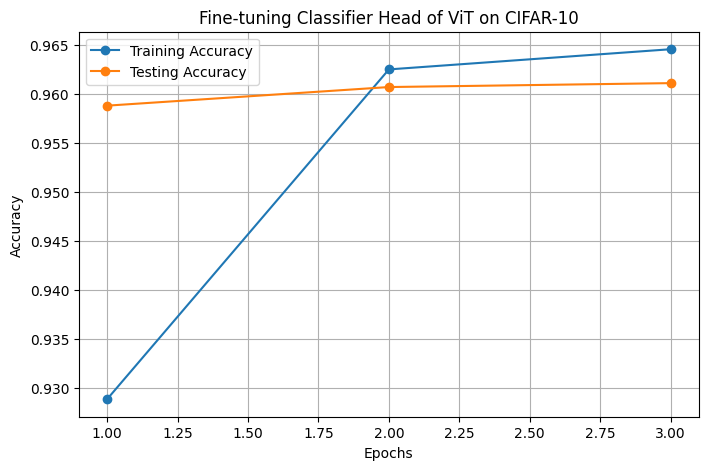

In [28]:
# Plotting the accuracy curves
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), test_accuracy_list, label='Testing Accuracy', marker='o')
plt.title('Fine-tuning Classifier Head of ViT on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()